# Contexto ✒️

Esse notebook se refere a uma introdução ao modelo de machine learning conhecido como XGBoost, relacionado a cenários de aprendizado supervisionado em que se busca realizar uma classificação ou previsão. Trata-se de um algoritmo de apredizagem supervisionado que implmenta um processo chamado boost para gerar dados mais precisos.

O modelo utiliza-se de árvores de decisão para seu modelo de conjunto, de modo que o modelo costuma ser impreciso, mas à medida que outros são criados, com base no erro do anterior, corrigindo-os cada modelo novo melhora as fraquezas do anterior, produzindo um modelo final preciso.

Possui resistência a geração de outliers, dados nulos, sendo bastante eficiente para dados tabulares e estruturados (não ocorrendo o mesmo para dados não estruturados). A sua principal deficiência, porém, se dá na presença de outliers, sendo sucetível a eles.

### Para mais informações sobre o XGBoost

https://medium.com/analytics-vidhya/introduction-to-xgboost-algorithm-d2e7fad76b04



## Bibliotecas 📚

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.figure_factory as ff

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score

In [2]:
!pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 1.1 MB/s eta 0:00:00


In [3]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical


## DataFrame 💾

In [4]:
url = 'https://raw.githubusercontent.com/alura-cursos/classificacao_xgboost/main/Dados/doenca_cardiaca.csv'


df = pd.read_csv(url)

## Analisando a qualidade dos dados

In [6]:
df.head()

,Idade,Sexo,Tipo dor,Pressao arterial,Colesterol,Glicemia jejum >120,Resultados ECG,Frequencia cardiaca max,Dor exercicio,Depressao ST,Inclinacao ST,Numero vasos fluro,Teste cintilografia,Doenca cardiaca
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,Presenca
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,Ausencia
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,Presenca
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,Ausencia
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,Ausencia


In [7]:
# Transformando as variáveis categóricas da variável
# target em numéricas :

df['Doenca cardiaca'] = df['Doenca cardiaca'].map({'Presenca': 1, 'Ausencia': 0})

In [8]:
df.head()

,Idade,Sexo,Tipo dor,Pressao arterial,Colesterol,Glicemia jejum >120,Resultados ECG,Frequencia cardiaca max,Dor exercicio,Depressao ST,Inclinacao ST,Numero vasos fluro,Teste cintilografia,Doenca cardiaca
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,1
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,0
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,1
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,0
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,0


In [9]:
df.isnull().sum()

Idade                      0
Sexo                       0
Tipo dor                   0
Pressao arterial           0
Colesterol                 0
Glicemia jejum >120        0
Resultados ECG             0
Frequencia cardiaca max    0
Dor exercicio              0
Depressao ST               0
Inclinacao ST              0
Numero vasos fluro         0
Teste cintilografia        0
Doenca cardiaca            0
dtype: int64

In [10]:
df.duplicated().sum()

0

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Idade                    270 non-null    int64  
 1   Sexo                     270 non-null    int64  
 2   Tipo dor                 270 non-null    int64  
 3   Pressao arterial         270 non-null    int64  
 4   Colesterol               270 non-null    int64  
 5   Glicemia jejum >120      270 non-null    int64  
 6   Resultados ECG           270 non-null    int64  
 7   Frequencia cardiaca max  270 non-null    int64  
 8   Dor exercicio            270 non-null    int64  
 9   Depressao ST             270 non-null    float64
 10  Inclinacao ST            270 non-null    int64  
 11  Numero vasos fluro       270 non-null    int64  
 12  Teste cintilografia      270 non-null    int64  
 13  Doenca cardiaca          270 non-null    int64  
dtypes: float64(1), int64(13)
m

In [12]:
# Formato dos dados.

df.shape

(270, 14)

In [13]:
# Verificando o balanceamento da variável target :

df['Doenca cardiaca'].value_counts('normalize').round(3)

Doenca cardiaca
0    0.556
1    0.444
Name: proportion, dtype: float64

In [26]:
# Verificando a proporção da classe em menor quantidade em relação
# ao universo dos dados e a classe com maior quantidade.

maior_classe = df[df['Doenca cardiaca'] == 0].shape[0]
menor_classe = df[df['Doenca cardiaca'] == 1].shape[0]

prop_classe = round((menor_classe / maior_classe), 3)
prop_dados = round((menor_classe / df.shape[0]), 3)

print(f'A proporção da classe com menos amostras em relação a que dispõe de mais : {prop_classe}')
print(f'A proporção da classe com menor amostras em relação aos dados totais : {prop_dados}')

A proporção da classe com menos amostras em relação a que dispõe de mais : 0.8
A proporção da classe com menor amostras em relação aos dados totais : 0.444


Observando a proporcionalidade dos dados, nota-se que esses, considrando a variável target, não estão balanceados.

Porém, ao observar a razão que a classe com menor quantidade de amostras apresenta em relação à classe que possuí maior quantidade, bem como em relação ao universo total dos dados, compreende-se que esse desbalanceamento não é agudo, uma vez que no primeiro caso representa por volta de 80% dos dados da classe com maior quantidade de amostras, assim como 44% dos dados totais.

Desse modo, não parece ser um cenário no qual deve-se, inadvertidamente, balancear os dados utilizando técnicas de balanceamento, tais como o da sub-amostragem ou sobre-amostragem, uma vez que a proporção do desbalanceamento é pequena, representando cerca de 6% dos dados totais.




In [27]:
df.describe()

,Idade,Sexo,Tipo dor,Pressao arterial,Colesterol,Glicemia jejum >120,Resultados ECG,Frequencia cardiaca max,Dor exercicio,Depressao ST,Inclinacao ST,Numero vasos fluro,Teste cintilografia,Doenca cardiaca
count,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.00000,270.000000,270.000000,270.000000,270.000000
mean,54.433333,0.677778,3.174074,131.344444,249.659259,0.148148,1.022222,149.677778,0.329630,1.05000,1.585185,0.670370,4.696296,0.444444
std,9.109067,0.468195,0.950090,17.861608,51.686237,0.355906,0.997891,23.165717,0.470952,1.14521,0.614390,0.943896,1.940659,0.497827
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.00000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,213.000000,0.000000,0.000000,133.000000,0.000000,0.00000,1.000000,0.000000,3.000000,0.000000
50%,55.000000,1.000000,3.000000,130.000000,245.000000,0.000000,2.000000,153.500000,0.000000,0.80000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,280.000000,0.000000,2.000000,166.000000,1.000000,1.60000,2.000000,1.000000,7.000000,1.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.20000,3.000000,3.000000,7.000000,1.000000


Analisando tanto a média quanto a medidana dos dados numéricos que não sejam booleanos, verifica-se que ambas são similares, permitindo inferir que no dataset não haja a presença significativa de outliers, que poderiam interferir negativamente na precisão dos modelos de machine learning, sem o tratamento desses.

## Exploração dos dados

Etapa destinada a compreensão dos dados, buscando verificar como eles se relacionam com a variável target, permitindo identificar possíveis insights e afins.

In [28]:
# Criando a função para gerar boxplots :

def gera_boxplot(variavel_x, variavel_y, data):

  plt.figure(figsize=(8,6))
  fig = px.box(data, x=variavel_x, y=variavel_y)
  fig.show()

In [29]:
# Criando função para gerar gráficos de contagem :

def gera_countplot(variavel_x, hue, data):

  plt.figure(figsize=(8,6))

  fig = px.histogram(data, x=variavel_x, color=hue, barmode='group')
  fig.update_layout(yaxis_title="Contagem")
  fig.update_traces(marker_line=dict(color='black', width=1))
  fig.show()

In [ ]:
gera_boxplot('Sexo', 'Idade', df)

<Figure size 800x600 with 0 Axes>

In [ ]:
gera_countplot('Sexo', 'Doenca cardiaca', df)

<Figure size 800x600 with 0 Axes>

Esse gráfico permite depreender a relação da presença da doença em ambos os sexos. Nele, é possível observar que, comparativamente, é mais prevalente nas pessoas do sexo masculino do que nas do sexo feminino.  

In [ ]:
gera_countplot('Tipo dor', 'Doenca cardiaca', data=df)

<Figure size 800x600 with 0 Axes>

Esse gráfico se relaciona aos tipos de dores que as pessoas podem sentir,estando cada qual agrupada em termos numéricos. Nota-se até a dor do tipo 4, a prevalência é maior para a ausência da doença, indicando que tais dores não são uma estrita indicação da presença da doença.

Esse contexto inverte, porém, justamente na dor tipo 4, na qual a prevalência da presença doença cardíaca além de ser significativa supera a sua ausência.

In [ ]:
gera_countplot('Idade', 'Doenca cardiaca', data=df)

<Figure size 800x600 with 0 Axes>

Analisando o gráfico da distribuição das idades em relação à presença da doença é possível notar que ela é mais frequente nas pessoas com idades mais avançadas, começando por volta dos 54 anos.

In [ ]:
gera_countplot('Dor exercicio', 'Doenca cardiaca', data=df)

<Figure size 800x600 with 0 Axes>

Visualizando o gráfico, nota-se que pessoas que realizam exercícios físicos e não sentem dor tendem, de forma mais prevalente, a não terem a presença da doença, enquanto que as pessoas que a sentem tedem, em maior proporção, ter a presença da doença.

### Analisando a distribuição da frequência cardíaca em relação à idade

In [ ]:
# Criar os subconjuntos para cada grupo

grupo_0 = df[df['Doenca cardiaca'] == 0]['Frequencia cardiaca max']
grupo_1 = df[df['Doenca cardiaca'] == 1]['Frequencia cardiaca max']

# Criar o gráfico de distribuição usando plotly.figure_factory

fig = ff.create_distplot(
    [grupo_0, grupo_1],
    group_labels=['Sem Doença Cardíaca', 'Com Doença Cardíaca'],
    colors=['green', 'red'],
    show_hist=True,  # Mostra o histograma
    show_rug=False,   # Oculta o gráfico de dispersão ("rug plot") abaixo do histograma
    curve_type='kde' # Usa a estimativa de densidade kernel (KDE) para a curva
)

# Configurar o layout do gráfico

fig.update_layout(
    title_text='Distribuição da Frequência Cardíaca Máxima em Relação à Doença Cardíaca',
    xaxis_title='Frequência Cardíaca Máxima',
    yaxis_title='Densidade',
    legend_title_text='Doença Cardíaca'
)

fig.show()

Gráfico que permite identificar a relação negativa entre frequência máxima cardíaca em relação a presença da doença, por meio de uma distribuição Gausiana. Nota-se que a frequência maior se refere melhor para cenários nos quais a doença não está presente, enquanto que ocorre o oposto para frequências menores.

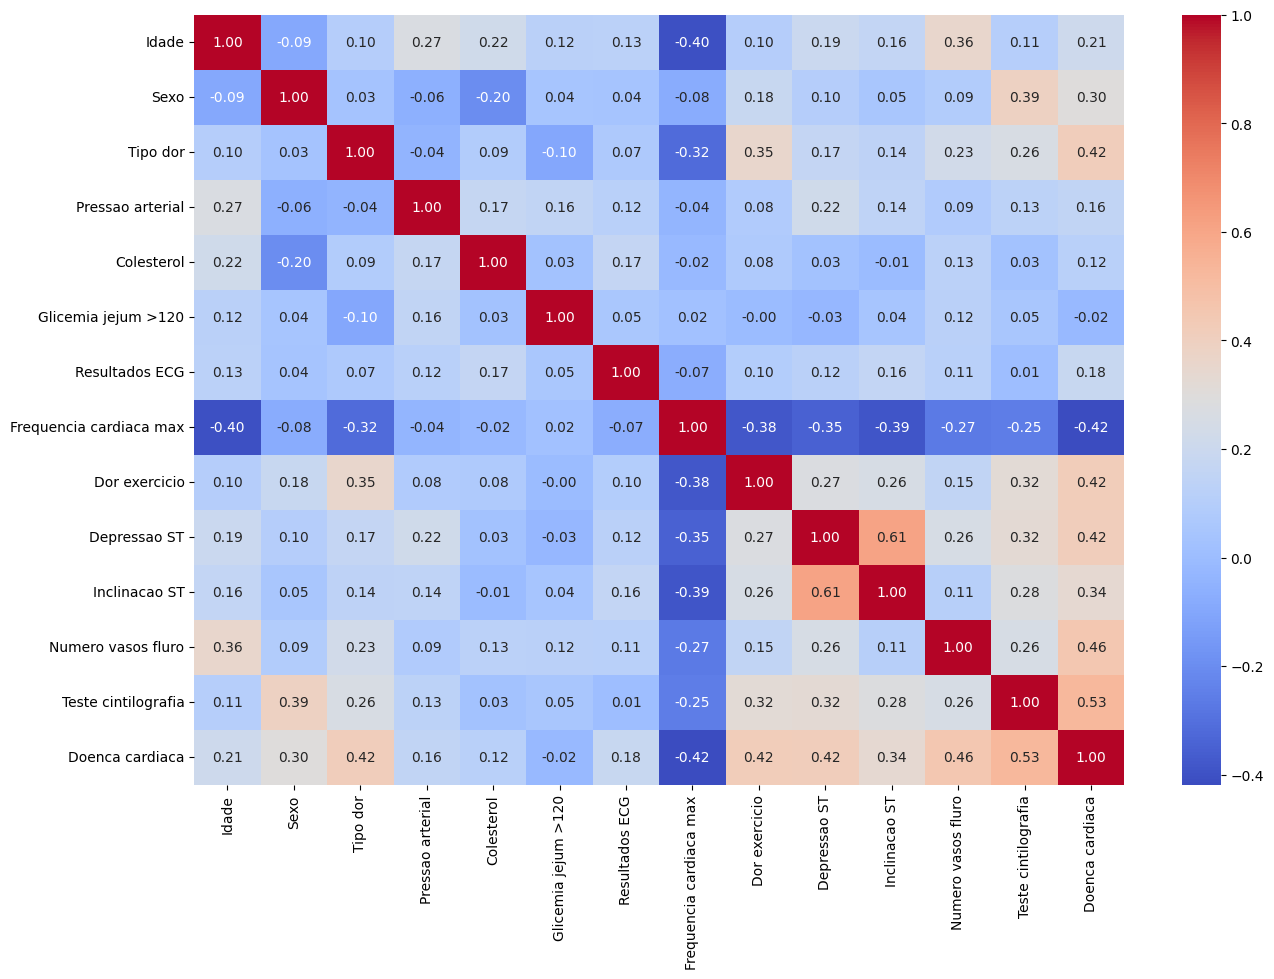

In [ ]:
m_corr = df.corr()

plt.figure(figsize=(15,10))
heatmap = sns.heatmap(m_corr, annot=True, cmap='coolwarm', fmt = '.2f')

## Implementando os modelos de machine learning 🤖

Havendo já realizada a etapa de análise da qualidade do dataframe e acerca das relações entre as features a variável target, úteis para identificar possíveis padrões nos dados, chega-se a etapa da implementação do modelo de machine learning, que será capaz de classifcar as features se pertecem ou não pertencem a um cenário em que há a presença da doença.

Antes da implementação dos modelos, propriamente dito, irei criar uma série de modelos de machine learning em seu formato padrão, os quais irão servir de baseline para os mesmos modelos otimizados, incluindo o XGBoost.

Tal abordagem é interessante, pois por meio dela permite identificar da melhor forma quais são os modelos mais adequados ao caso e que possam desempenhar da melhor forma sobre o conjunto de dados presentes.

In [30]:
SEED = 22

In [31]:
# Separando em X e em y:

X = df.drop('Doenca cardiaca', axis=1)
y = df['Doenca cardiaca']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= SEED)

In [33]:
# Instanciando os modelos :

random_forest_default = RandomForestClassifier(random_state=SEED)
logistic_regression_default = LogisticRegression(random_state=SEED)
xgboost_default = XGBClassifier(random_state=SEED)
knn_default = KNeighborsClassifier()

In [ ]:
def avalia_modelos(nome_modelo, modelo):

  modelo.fit(X_train, y_train)
  y_pred = modelo.predict(X_test)

  acuracia = accuracy_score(y_test, y_pred).round(3)
  recall = recall_score(y_test, y_pred).round(3)
  precision = precision_score(y_test, y_pred).round(3)
  f1 = f1_score(y_test, y_pred).round(3)

  print(f'\n{nome_modelo}\n')

  print(f'Acurácia: {acuracia}')
  print(f'Recall: {recall}')
  print(f'Precision: {precision}')
  print(f'F1 Score: {f1}')

In [ ]:
import warnings
from sklearn.exceptions import ConvergenceWarning

# Para ignorar avisos de convergência gerados pelo
# modelo de regressão logística.

warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [ ]:
modelos = [
    ('Random Forest (default)', random_forest_default),
    ('Logistic Regression (default)', logistic_regression_default),
    ('XGBoost (default)', xgboost_default),
    ('KNN (default)', knn_default)
]

for nome_modelo, modelo in modelos:
  avalia_modelos(nome_modelo, modelo)


Random Forest (default)

Acurácia: 0.833
Recall: 0.783
Precision: 0.818
F1 Score: 0.8

Logistic Regression (default)

Acurácia: 0.87
Recall: 0.783
Precision: 0.9
F1 Score: 0.837

XGBoost (default)

Acurácia: 0.815
Recall: 0.783
Precision: 0.783
F1 Score: 0.783

KNN (default)

Acurácia: 0.685
Recall: 0.652
Precision: 0.625
F1 Score: 0.638


Analisando as métricas encontradas por meio da função que avalia os modelos de machine learning, pode-se compreender que os modelos que, segundo a literatura, apresentam maior robustez ao lidar com dados não normalizados ou sujeitos a um mesmo intervalo desempenham melhor, sendo desses apenas o de regressão logística que não é construído, em seu âmago, por árvores de decisão.

Não obstante, analisando com maior cuidado os modelos que já apresentaram boas pontuações, nota-se que o XGBoost apesar dentre eles ser o que obteve a menor pontuação, pode apresentar via otimização um ganho de desempenho interessante.

Ao final da otimização irei comparar novamente os modelos otimizados entre si, considerando inclusive a curva AUC, para analisar qual modelo desempenhou melhor para o presente caso de uso.

## Otimizando os modelos de machine learning

### Definindo os hiperparâmetros de busca para cada modelo

In [36]:
# Hiperparâmetros para o Random Forest :

params_rf = {
    'n_estimators': Integer(50, 500),
    'max_depth': Integer(2, 10),
    'min_samples_split': Integer(2, 20),
    'min_samples_leaf': Integer(2,20),
    'criterion': Categorical(['gini', 'entropy']),
    'max_features': Categorical(['sqrt', 'log2'])
}

# Hiperparâmetros para a Regressão Logística :

params_lg = {
    'C': Real(0.01, 10),
    'max_iter': Integer(100, 300),
    'penalty': Categorical(['l1', 'l2']),
    'solver': Categorical(['liblinear'])
}

# Hiperparâmetros para o XGBoost :

params_xgb = {
    'n_estimators': Integer(50, 500),
    'max_depth': Integer(2, 10),
    'learning_rate': Real(0.01, 0.3),
    'subsample': Real(0.5,1),
    'colsample_bytree': Real(0.5,1)
}

# Hiperparâmetros para o K-Nierst Neighbors :

params_knn = {
    'n_neighbors': Integer(3,10),
    'weights': Categorical(['uniform', 'distance']),
    'metric': Categorical(['euclidean', 'manhattan'])
}

O algoritmo de otimização escolhido será a modelo de otmização bayesiana, o qual construído com influência no teorema de Bayes, otimiza o modelo de machine learning conjungando a informação anterior, buscand encontrar uma nova posterior. Em termos práticos, significa dizer que por meio da função de custo ela avalia cada combinação de modelo iterativamente, passando a buscar, a cada passo, a melhor combinação de hiperparâmetros que promovam o ponto de ótimo.

Para mais explicação sobre como procede esse otimizador, recomendo olhar o notebook no qual eu debruço sobre o tema, bem como checar o link a seguir : https://medium.com/@beniciowg/como-tunar-hiperparâmetros-com-otimização-bayesiana-5687fd51370f

In [38]:
# Para a validação, unindo o otimizador bayesiano,
# irei me utilizar da validação cruzada aninhada, a
# qual visa cumprir justamente que os modelos elaborados
# não apresentem otimismo quanto as previsões, reduzindo
# ao máximo o risco ao overfiting nos dados.

# Porção interna :
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)

# Porção externa:
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

### Otimizando o Random Forest 🌳🌳🌳

In [ ]:
# Instanciando o otimizador bayesiano

rf_opt_bayesian = BayesSearchCV(
    estimator = RandomForestClassifier(random_state = SEED),
    search_spaces = params_rf,
    n_iter = 50,
    scoring = 'recall',
    n_jobs = -1,
    cv = inner_cv)

In [ ]:
%%time

# Encontrando a acurácia da etapa de treinamento :

rf_nested_score = cross_val_score(rf_opt_bayesian, X_train, y_train, cv = outer_cv)

CPU times: user 8min 54s, sys: 5min 17s, total: 14min 11s
Wall time: 16min 14s


In [ ]:
# Encontrando a acurácia média do treinamento :

rf_nested_mean_score = rf_nested_score.mean().round(3)

In [ ]:
print(f'Acurácia média da validação cruzada aninhada do Random Forest : {rf_nested_mean_score}')

Acurácia média da validação cruzada aninhada: 0.752


In [ ]:
%%time

# Treinando o modelo para visualizar os melhores hiperparâmetros :

rf_opt_bayesian.fit(X_train, y_train)

CPU times: user 1min 37s, sys: 58.6 s, total: 2min 35s
Wall time: 2min 53s


BayesSearchCV(cv=StratifiedKFold(n_splits=3, random_state=22, shuffle=True),
              estimator=RandomForestClassifier(random_state=22), n_jobs=-1,
              scoring='recall',
              search_spaces={'criterion': Categorical(categories=('gini', 'entropy'), prior=None),
                             'max_depth': Integer(low=2, high=10, prior='uniform', transform='normalize'),
                             'max_features': Categorical(categories=('sqrt', 'log2'), prior=None),
                             'min_samples_leaf': Integer(low=2, high=20, prior='uniform', transform='normalize'),
                             'min_samples_split': Integer(low=2, high=20, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=50, high=500, prior='uniform', transform='normalize')})

In [ ]:
# Visualizando os melhores hiperparâmetros :

rf_opt_bayesian.best_params_

OrderedDict([('criterion', 'gini'),
             ('max_depth', 10),
             ('max_features', 'log2'),
             ('min_samples_leaf', 2),
             ('min_samples_split', 3),
             ('n_estimators', 50)])

In [ ]:
# Instanciando o modelo otimizado :

random_forest_opt = RandomForestClassifier(
    n_estimators = 50,
    max_depth = 10,
    max_features = 'log2',
    criterion = 'gini',
    min_samples_leaf = 2,
    min_samples_split = 3,
    random_state = SEED)

## Otimizando o modelo de regressão logística 📈

In [ ]:
# Instanciando o otimizador bayesiano

lr_opt_bayesian = BayesSearchCV(
    estimator = LogisticRegression(random_state = SEED),
    search_spaces = params_lg,
    n_iter = 50,
    scoring = 'recall',
    n_jobs = -1,
    cv = inner_cv)

In [ ]:
%%time

# Encontrando a acurácia da etapa de treinamento :

lr_nested_score = cross_val_score(lr_opt_bayesian, X_train, y_train, cv = outer_cv)

CPU times: user 7min 47s, sys: 4min 32s, total: 12min 19s
Wall time: 10min 57s


In [ ]:
# Encontrando a acurácia média da etapa de treinamento :

lr_nested_mean_score = rf_nested_score.mean().round(3)

print(f'Acurácia média da validação cruzada aninhada do L. Regression : {lr_nested_mean_score}')

Acurácia média da validação cruzada aninhada do L. Regression : 0.752


In [ ]:
%%time

# Treinando novamente o modelo para visualizar os melhores hiperparâmetros :

lr_opt_bayesian.fit(X_train, y_train)

CPU times: user 1min 27s, sys: 55.4 s, total: 2min 22s
Wall time: 1min 58s


BayesSearchCV(cv=StratifiedKFold(n_splits=3, random_state=22, shuffle=True),
              estimator=LogisticRegression(random_state=22), n_jobs=-1,
              scoring='recall',
              search_spaces={'C': Real(low=0.01, high=10, prior='uniform', transform='normalize'),
                             'max_iter': Integer(low=100, high=300, prior='uniform', transform='normalize'),
                             'penalty': Categorical(categories=('l1', 'l2'), prior=None),
                             'solver': Categorical(categories=('liblinear',), prior=None)})

In [ ]:
# Encontrando os melhores hiperparâmetros :

lr_opt_bayesian.best_params_

OrderedDict([('C', 4.330084702341494),
             ('max_iter', 295),
             ('penalty', 'l2'),
             ('solver', 'liblinear')])

In [ ]:
# Instanciando o melhor modelo encontrado :

logistic_regression_opt = LogisticRegression(
    C = 4.33,
    max_iter = 295,
    penalty = 'l2',
    solver = 'liblinear',
    random_state = SEED)

## Otimizando o XGBoost 🌳🌳

In [ ]:
# Instanciando o otimizador bayesiano

xgb_opt_bayesian = BayesSearchCV(
    estimator = XGBClassifier(random_state=SEED),
    search_spaces = params_xgb,
    n_iter = 50,
    scoring = 'recall',
    n_jobs = -1,
    cv = inner_cv)

In [ ]:
%%time

# Encontrando a acurácia da etapa de treinamento :

xgb_nested_score = cross_val_score(xgb_opt_bayesian, X_train, y_train, cv = outer_cv)

CPU times: user 9min 21s, sys: 4min 53s, total: 14min 15s
Wall time: 12min 47s


In [ ]:
# Encontrando a acurácia média da etapa de treinamento :

xgb_mean_score = xgb_nested_score.mean().round(3)

print(f'Acurácia média da validação cruzada aninhada do XGBoost : {xgb_mean_score}')

Acurácia média da validação cruzada aninhada do XGBoost : 0.753


In [ ]:
%%time

# Treinando novamente o modelo para verificar seus melhores hiperparâmetros :

xgb_opt_bayesian.fit(X_train, y_train)

CPU times: user 1min 34s, sys: 59.3 s, total: 2min 33s
Wall time: 1min 53s


BayesSearchCV(cv=StratifiedKFold(n_splits=3, random_state=22, shuffle=True),
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None, device=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric=None, feature_types=None,
                                      gamma=None, grow_policy=None,
                                      importance_ty...
              search_spaces={'colsample_bytree': Real(low=0.5, high=1, prior='uniform', transform='normalize'),
                             'learning_rate': Real(low=0.01, high=0.3, prior='uniform', transform='normalize'),
                             'max_depth': Integer(low=2, high=10, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=50, high=500, prior='uniform', transform='normalize'),
                             'subsample': Real(low=0.5, high=1, prior='uniform', transform='normalize')})

In [ ]:
# Encontrando os melhores hiperparâmetros :

xgb_opt_bayesian.best_params_

OrderedDict([('colsample_bytree', 0.5),
             ('learning_rate', 0.2410079918879401),
             ('max_depth', 2),
             ('n_estimators', 388),
             ('subsample', 0.5248097306845334)])

In [34]:
# Instanciando o melhor modelo encontrado :

xgb_opt_bayesian = XGBClassifier(
    n_estimators = 388,
    max_depth = 2,
    learning_rate = 0.24,
    subsample = 0.52,
    colsample_bytree = 0.5,
    random_state = SEED)


## Otimizando o K-Nierst Neighbors 📏

In [39]:
# Instanciando o otimizador bayesiano

knn_opt_bayesian = BayesSearchCV(
    estimator = KNeighborsClassifier(),
    search_spaces = params_knn,
    n_iter = 50,
    scoring = 'recall',
    n_jobs = -1,
    cv = inner_cv)

In [ ]:
%%time

# Encontrando a acurácia da etapa de treinamento :

knn_nested_score = cross_val_score(knn_opt_bayesian, X_train, y_train, cv = outer_cv)

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point ['euclidean', 3, 'distance'] before, using random point ['manhattan', 4, 'distance']
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point ['euclidean', 3, 'distance'] before, using random point ['euclidean', 5, 'uniform']
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point ['manhattan', 3, 'distance'] before, using random point ['euclidean', 4, 'uniform']
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point ['euclidean', 3, 'distance'] before, using random point ['euclidean', 4, 'uniform']
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserW

CPU times: user 6min 11s, sys: 4min 13s, total: 10min 25s
Wall time: 7min 4s


In [ ]:
# Encontrando a acurácia média da etapa de treinamento :

knn_mean_score  = knn_nested_score.mean().round(3)

print(f'Acurácia média da validação cruzada aninhada do K-Nierst Neighbors : {knn_mean_score}')

Acurácia média da validação cruzada aninhada do K-Nierst Neighbors : 0.606


In [ ]:
%%time

# Treinando novamente o modelo para verificar seus melhores hiperparâmetros :

knn_opt_bayesian.fit(X_train, y_train)


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point ['manhattan', 7, 'uniform'] before, using random point ['manhattan', 6, 'uniform']
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point ['manhattan', 7, 'uniform'] before, using random point ['euclidean', 6, 'distance']
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point ['euclidean', 6, 'uniform'] before, using random point ['manhattan', 4, 'uniform']
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point ['manhattan', 7, 'uniform'] before, using random point ['euclidean', 8, 'uniform']
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarni

CPU times: user 1min 14s, sys: 50.5 s, total: 2min 4s
Wall time: 1min 23s


BayesSearchCV(cv=StratifiedKFold(n_splits=3, random_state=22, shuffle=True),
              estimator=KNeighborsClassifier(), n_jobs=-1, scoring='recall',
              search_spaces={'metric': Categorical(categories=('euclidean', 'manhattan'), prior=None),
                             'n_neighbors': Integer(low=3, high=10, prior='uniform', transform='normalize'),
                             'weights': Categorical(categories=('uniform', 'distance'), prior=None)})

In [ ]:
# Para encontrar os melhores hiperparâmetros :

knn_opt_bayesian.best_params_

OrderedDict([('metric', 'manhattan'),
             ('n_neighbors', 7),
             ('weights', 'uniform')])

In [ ]:
# Instanciando o melhor modelo encontrado :

knn_opt_bayesian = KNeighborsClassifier(
    n_neighbors = 7,
    weights = 'uniform',
    metric = 'manhattan')

## Avaliando os modelos otimizados

In [ ]:
modelos = [
    ('Random Forest (opt)', random_forest_opt),
    ('Logistic Regression (opt)', logistic_regression_opt),
    ('XGBoost (opt)', xgb_opt_bayesian),
    ('KNN (opt)', knn_opt_bayesian)
]

for nome_modelo, modelo in modelos:
  avalia_modelos(nome_modelo, modelo)


Random Forest (opt)

Acurácia: 0.833
Recall: 0.783
Precision: 0.818
F1 Score: 0.8

Logistic Regression (opt)

Acurácia: 0.87
Recall: 0.783
Precision: 0.9
F1 Score: 0.837

XGBoost (opt)

Acurácia: 0.815
Recall: 0.826
Precision: 0.76
F1 Score: 0.792

KNN (opt)

Acurácia: 0.741
Recall: 0.696
Precision: 0.696
F1 Score: 0.696


Analisando os modelos otimizados com a otimização bayesiana sujeita a uma validação cruzada aninhada, nota-se que alguns modelos apresentaram significativa melhora, como o KNN, ainda que seja inferior aos demais outros, bem como o XGBoost, que obteve uma melhora em seu recall, sendo o modelo com a maior taxa dessa métrica entre todos.

Outro modelo que se destaca é o de regressão logística, o qual apresenta a maior média harmônica dos modelos otimizados, justamente por conta da sua elevada precisão, que para seu calculo considera a razão de verdadeiros positivos por falsos positivos mais verdadeiros positivos.

Uma vez que o presente notebook apresenta um estudo de caso referente a classificação de pessoas que podem ou não ter doença cardíaca, uma vez que para o cálculo da recall cria-se uma razão de VP / VP + FN, iremos escolhê-la como critério para a seleção do modelo escolhido, além de considerar a matriz de confusão e curva AUC.

## Matriz de confusão 😵‍💫

Irei analisar a matriz de confusão de dois modelos que desempenharam bem segundo as métricas adotadas, sendo o modelo de regressão logística e o XGBoost, que, respectivamente, oferecam a maior precisão e recall.

A análise da matriz visa adicionar uma nova camada de análise, buscando compreender dentre esses qual foi o melhor modelo.

In [ ]:
# Obtendo as classes únicas presentes em y_test :

classes = sorted(set(y_test))

### Matriz de confusão ao modelo de regresssão logística

In [ ]:
# Criando a matriz de confusão para o modelo de regressão logística :

cm_lr = confusion_matrix(y_test, logistic_regression_opt.predict(X_test))

fig = px.imshow(cm_lr,
                labels=dict(x="Previsto", y="Real", color = "Contagem"),
                x = classes,
                y = classes,
                text_auto=True,
                color_continuous_scale='viridis')

# Ajustando o tamanho e a cor do texto
fig.update_traces(textfont_size=16, textfont_color='blue')

fig.update_layout(title_text="Matriz de Confusão", title_x=0.5)
fig.show()

Analisando a matriz de confusão para o modelo de regresão logística, nota-se que ele acerta, considerando tanto os verdadeiros negativos quanto postivos, cerca de 47 vezes, errando 7 vezes, mostrando uma eficiência de aproximadamente 0.88 (ou 88%).

### Criando a matriz de confusão ao modelo XGBoost

In [ ]:
# Criando a matriz de confusão para o modelo de regressão logística :

cm_xgb = confusion_matrix(y_test, xgb_opt_bayesian.predict(X_test))

fig = px.imshow(cm_xgb,
                labels=dict(x="Previsto", y="Real", color = "Contagem"),
                x = classes,
                y = classes,
                text_auto=True,
                color_continuous_scale='viridis')

# Ajustando o tamanho e a cor do texto
fig.update_traces(textfont_size=16, textfont_color='blue')

fig.update_layout(title_text="Matriz de Confusão", title_x=0.5)
fig.show()

Analisando a matriz de confusão para o modelo XGBoost, nota-se que ele possui uma taxa de acerto, considerando tanto verdadeiros positivos quantos verdadeiros negativos, de aproximadamente 0.81 (ou 81%), acertando 44 vezes e errando 10 vezes. Comparando-o com o modelo anterior, é possível compreender que, segundo a matriz de confusão ele é um pouco inferior, com perda percentual de 7%, em relação ao modelo de regressão logística.

Não obstante, é possível identificar que os valores encontrados, referente ao desempenho geral do modelo, na matriz de confusão é similar ao oferecido pela métrica acurácia, de modo que ambas mostram valores semelhantes para cada modelo no escopo da taxa de acerto de cada qual.



## Analisando os modelos com a curva ROC 🔬

In [ ]:
# Criando as variáveis que armazenam as previsões de cada modelo :

xgb_opt_predict = xgb_opt_bayesian.predict(X_test)
lr_opt_predict = logistic_regression_opt.predict(X_test)

In [ ]:
def cria_curva_roc(y_pred, nome_modelo):

  RocCurveDisplay.from_predictions(y_test, y_pred, name = nome_modelo);



### Curva ROC - XGBoost

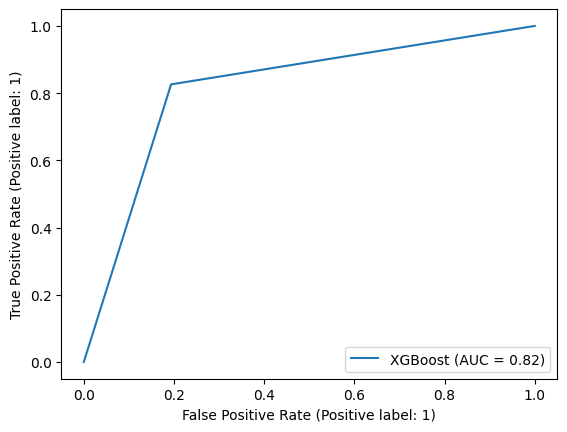

In [ ]:
cria_curva_roc(xgb_opt_predict, 'XGBoost')

### Curva ROC - Logistic Regression

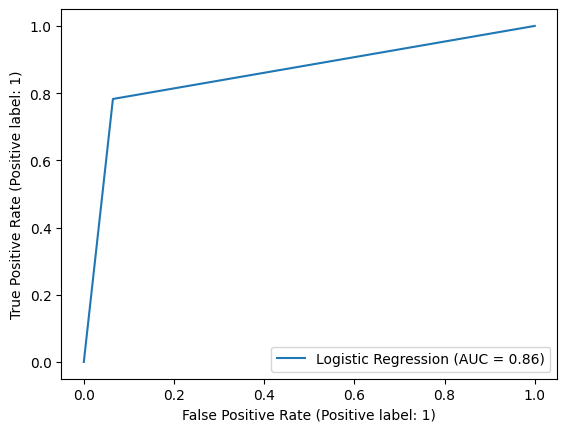

In [ ]:
cria_curva_roc(lr_opt_predict, 'Logistic Regression')

Lembrando, tal curva se refere à compreensão do quanto o modelo está sendo capaz de ser assertivo quanto as suas previsões para verdadeiros positivos e verdadeiros negativos.

Nesse sentido, analisando ambas as curvas, nota-se que ambos os modelos apresentam desempenham semelhante, sendo a diferença entre eles de apenas 0.04 ou 4%.

## Conclusão

### Seleção dos modelos 🤖

Após a criação dos modelos otimizados, observou-se que os melhores modelos em termos de desempenho foram o modelo de regressão, tanto por sua acurácia quanto pela precisão, bem como o XGBoost, por meio de seu recall.

Desse modo, verificou-se de forma mais profunda sobre cada um deles, buscando ver o quão precisos eram tanto por meio da matriz de confusão quanto pela curva ROC-AUC, de modo que percebeu-se que em termos de desempenho geral o modelo de regressão possui um ganho de 7 pontos percentuais em relação ao XGBoost, com 4 pontos percentuais de maior precisão, segundo a própria curva.

Por outro lado, considerando o presente estudo de caso, para a seleção do modelo de machine learning adotado, o qual se baseia na classificação de pacientes com doença cardíaca ou não, faz-se necessário escolher o modelo que apresenta a maior recall, que manifesta a maior taxa de acerto efetivo.

Assim, tendo em vista que o XGBoost em outras métricas, como taxa de acerto geral e curva ROC-AUC apresenta pouca desvantagem percentual em relação ao modelo de regressão logística, bem como apresenta em relação a esse maior recall, considera-se para o vigente contexto que ele é o melhor modelo a ser escolhido.

## Identificando quais foram as features mais relevantes segundo o modelo selecionado 🔍

In [ ]:
%%time

xgb_opt_bayesian.fit(X_train, y_train)

CPU times: user 1.01 s, sys: 7.45 ms, total: 1.02 s
Wall time: 1.18 s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.24, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=388, n_jobs=None,
              num_parallel_tree=None, random_state=22, ...)

In [ ]:
feature_importance = pd.DataFrame({'colunas' : X_train.columns, 'importancia' : xgb_opt_bayesian.feature_importances_})

feature_importance.sort_values(by = 'importancia', ascending = False)

,colunas,importancia
11,Numero vasos fluro,0.130256
8,Dor exercicio,0.114581
2,Tipo dor,0.093217
1,Sexo,0.086178
12,Teste cintilografia,0.083835
5,Glicemia jejum >120,0.080850
9,Depressao ST,0.071760
10,Inclinacao ST,0.064923
7,Frequencia cardiaca max,0.061850
4,Colesterol,0.056779


## Insights a partir dos dados ✨

Através dos dados, permitiu-se observar algumas relações, como a tendência diretamente proporcional entre idade e a presença da doença, assim como a prevalência dessa no sexo masculino, estando em menor grau no sexo feminio, o que sugerem caminhos a serem pesquisados para que possam ser melhor compreendidos, além das possíveis combinações entre dados que poderiam ser feitas, como idade e frequência cardíaca, a qual apresenta uma relação inversamente proporcional com a presença da doença.

Da mesma forma, pode-se observar quais foram as features mais relevantes para o modelo, na etapa de treinamento, compreender a presença ou ausência da doença. Por exemplo, nota-se que as features referentes aos vasos, dor durante o exercício e o tipo de dor sentida pelo paciente são bastante significativos para a possível presença da doença, equanto outras features como frequência cardíaca máxima menos.

No entanto, como o foco desse notebook não era de propriamente dito realizar a interpretação dos dados, mas apenas a implementação do modelo XGBoost, passando pelo escopo de sua otmização e análise métrica em conjunto de outros modelos, a parte dos possíveis insights em meio aos dados não será aprofundada.


## Salvando o modelo selecionado 🚀

In [ ]:
modelo_xgb = xgb_opt_bayesian

In [ ]:
import pickle

with open('modelo_xgb.pkl', 'wb') as arquivo:
    pickle.dump(modelo_xgb, arquivo)